In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("etl.csv")
df.describe()

Unnamed: 0  MEMORY_UTILIZATION_PERCENT
count   43.000000                   43.000000
mean    21.000000                   34.122093
std     12.556539                   14.875346
min      0.000000                   20.000000
25%     10.500000                   23.000000
50%     21.000000                   25.000000
75%     31.500000                   51.205000
max     42.000000                   57.780000

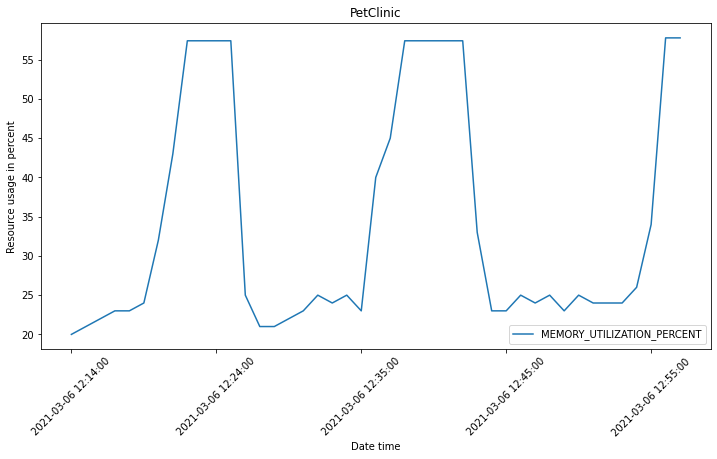

In [2]:
MEMORY = 'MEMORY_UTILIZATION_PERCENT'
CPU = 'CPU_UTILIZATION_PERCENT'
HOSTNAME = 'hostname'
METRICS = [MEMORY]
host = pd.unique(df[HOSTNAME])[0]
#ƒor host, for day...eventually
df_host = df.loc[df.hostname==host]
#Missing values strategy
df_host = df_host.dropna()
# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(strategy='median')
# df_host[METRICS] = imp.fit_transform(df_host[METRICS])

### Draw data
df_host.plot(x='datetime', y=METRICS, subplots=True, figsize=(12,6))
plt.xticks(rotation = 45)
plt.xlabel('Date time')
plt.ylabel('Resource usage in percent')
plt.title(host)

plt.show()


## Windows generation

In [3]:

#### Window generation
CLASS='class'
WINDOW_SIZE=6
DATETIME='datetime'
WINDOWS = dict()#map metric to metric window column
WINDOW_START='WINDOW_START'
WINDOW_END='WINDOW_END'
df_window =pd.DataFrame(df_host)

def get_roller_as_list(frame,pos=None):
    # Obtains values from a frame rolling window as list
    values = list()
    for a in list(frame.rolling(WINDOW_SIZE)):
        if(pos!=None):
            values.append(list(a)[pos])
        else:
            values.append(list(a))
    return values
def roller_window_select_first(frame):
    # from rolling window selects the first element
    FIRST_POSITION=0
    return get_roller_as_list(frame,FIRST_POSITION)
def roller_window_select_last(frame):
    # from rolling window selects the last element
    LAST_POSITION=-1
    return get_roller_as_list(frame,LAST_POSITION)


for metric in METRICS:
    window_name = metric + "_WINDOW"
    WINDOWS[metric] = window_name
    df_window[window_name] = np.asarray(get_roller_as_list(df_window[metric]))
# Once all windows were calculated, we label window according to last value of window
df_window[CLASS] = roller_window_select_last(df_window[CLASS])
 # Start Date, end Date
df_window[WINDOW_START] = roller_window_select_first(df_window[DATETIME])
df_window[WINDOW_END]= roller_window_select_last(df_window[DATETIME])

#Filtering vectors that dont match the window size.
for window_name in WINDOWS.values():
    df_window = df_window[df_window[window_name].map(len)==WINDOW_SIZE].copy()


df_window = pd.DataFrame(df_window)
#exploding windows
FEATURE_COLUMNS = list()
for window_name in WINDOWS.values():
    for i in range(WINDOW_SIZE):
        feature_name = window_name+"_"+str(i)
        df_window[feature_name] = df_window[window_name].apply(lambda x: np.array(x)[i])
        FEATURE_COLUMNS.append(feature_name)
COLS = [HOSTNAME,WINDOW_START,WINDOW_END,CLASS] + METRICS + FEATURE_COLUMNS
df_window = pd.DataFrame(df_window[COLS])

/home/max/Qupe/PG/scikit-poc/env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


## Model 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.pipeline import make_pipeline

#Pre-procesing
le = LabelEncoder()
X = df_window[FEATURE_COLUMNS]
y = df_window[[CLASS]].values.ravel()
#labeling classes
le.fit(y)
y = le.transform(y)

# split test and train data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,random_state=1)


# Create linear regression object
from sklearn.neighbors import KNeighborsClassifier
regr = make_pipeline(StandardScaler(), KNeighborsClassifier())

# Train the model using the training sets
regr.fit(X_train, y_train)

# Measure predictions using the testing set
regr.score(X_test,y_test)

1.0

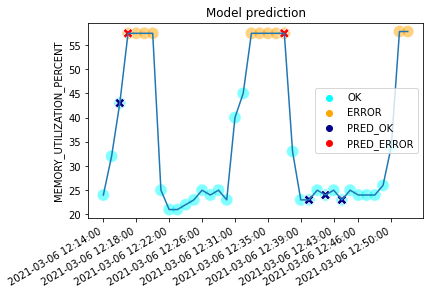

In [5]:
# Prediction diagram
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

cmap_light = ['cyan','orange']
cmap_bold = ['darkblue','red']
pred = regr.predict(X_test)

fig, ax = plt.subplots()
sns.lineplot(x=df_window[WINDOW_START], y=df_window[MEMORY], ax=ax)
test_subset = df_window.loc[X_test.index]
sns.scatterplot(x=df_window[WINDOW_START], y=df_window[MEMORY], hue=df_window[CLASS] ,ax=ax, alpha=.5,s=150, palette=cmap_light)
sns.scatterplot(x=test_subset[WINDOW_START], y=test_subset[MEMORY],hue=[f'PRED_{i}' for i in le.inverse_transform(pred)], ax=ax,s=100,marker='X',palette=cmap_bold)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.autofmt_xdate()
plt.title(label="Model prediction")
plt.xlabel(None)
ax.legend()
plt.show()
